In [39]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


import pandas as pd
import numpy as np
import seaborn as sns

from fractions import Fraction as frac

SEED = 1337

pd.set_option('display.max_rows', 500)
%matplotlib inline

# Setting Spark Sesson and Context

In [19]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("fa21-ds5110-group10-xh") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

In [20]:
spark.sparkContext

<SparkContext master=local[*] appName=fa21-ds5110-group10-xh>

First we add in our cached dataset from our prior feature engineering.

# Read input file

In [21]:
df = spark.read.parquet("../../../data/processed/training.parquet")
testing_df = spark.read.parquet("../../../data/processed/testing.parquet")

df_all = spark.read.parquet("../../../data/processed/chess_games_moves_model.parquet")

In [22]:
df.cache()

DataFrame[event: string, white_result: string, first_two: array<string>, ECO: string, EloDiff: int, Opening: string, game_complexity: int]

Next we review the resulting data points of interest.
We notice that ECO and the first two sets of moves are distinct of one another, and may influence the overall model's prediction.

In [23]:
print("First Turns: {}".format(df.select("first_two").distinct().count()))
print("ECO Types: {}".format(df.select("ECO").distinct().count()))
print("Opening Variants: {}".format(df.select("Opening").distinct().count()))
print( df.groupBy('first_two').count().sort(F.col("count").desc()).show(5), df.count())

First Turns: 289154
ECO Types: 491
Opening Variants: 2832
+------------------+------+
|         first_two| count|
+------------------+------+
|  [e4 e5, Nf3 Nc6]|199152|
|   [e4 e5, Nf3 d6]| 77714|
|[e4 d5, exd5 Qxd5]| 51726|
|  [e4 c5, Nf3 Nc6]| 46965|
|    [e4 e6, d4 d5]| 43334|
+------------------+------+
only showing top 5 rows

None 2308233


# Feature Engineering (Feature Pipeline)

We will now begin to build a model, keying in on the opening move and the white_result columns.
Note that both of these are categorical values, so we will need to encode them using the StringIndexer for pyspark to do model evaluations.

In [24]:
opening_vectorizor = StringIndexer(inputCol="ECO", outputCol="opening_ohe")
gametype_vectorizer = StringIndexer(inputCol="event", outputCol="event_vector")
result_vectorizor = StringIndexer(inputCol="white_result", outputCol="white_result_vector")

Next we perform One-Hot Encoding on our Opening type (or ECO) and do our comparision.  THis will create a new column that we will use for our random forest model.

In [25]:
move_encoder = OneHotEncoder(inputCols=["opening_ohe"],
                             outputCols=["ECO_Type"])

Now that we have the OHE of our ECO, we can combine it with other features to build out our predictors for random forest.

In [26]:
features_assembler = VectorAssembler(inputCols=['ECO_Type', "EloDiff", "event_vector"], outputCol='features')

Now that our data is model-ready, we will do a split, fit, transform, and evaluation to determine the performance of our model.
Note that we have chosen the default tunings, but in the future we will likely apply a cross-validation technique in pyspark to select the correct hyperparameters.

In [27]:
feature_pipeline = Pipeline(stages=[opening_vectorizor,
                                    gametype_vectorizer,
                                    result_vectorizor,
                                    move_encoder,
                                   features_assembler])

# Build a RandomForest Model based on One Set of Pre-defined Params

In [28]:
rf = RandomForestClassifier(numTrees=20, maxDepth=5, featuresCol='features', labelCol='white_result_vector', seed=SEED, leafCol="leafId")

In [29]:
# Create our transforms from our full dataset (considers all cases)
feature_model_df = feature_pipeline.fit(df_all)

# Transform both training and testing dfs
trainingData = feature_model_df.transform(df)
testingData = feature_model_df.transform(testing_df)

In [30]:
model = rf.fit(trainingData)

## Obtain Area Under the Curve

In [31]:
prediction = model.transform(testingData)

In [32]:
auc_evaluator = BinaryClassificationEvaluator(labelCol='white_result_vector', metricName='areaUnderROC')
model_auc = auc_evaluator.evaluate(prediction)

In [33]:
print("Model AreaUnderROC: {}".format(model_auc))

Model AreaUnderROC: 0.645514656339821


Here we see that our model's performance seems to work well, with roughtly 50% of games resulting in a match to white win.

Let's review our classifications and confusion matrix next to determine the overall performance.

## Obtain Confusion Matrix

In [34]:
designer_matrix = prediction.select(['prediction','white_result_vector'])
metrics_rdd = MulticlassMetrics(designer_matrix.rdd.map(tuple))
print(metrics_rdd.confusionMatrix().toArray())

[[383201. 198561.]
 [228342. 346018.]]


Reviewing this model, we see that this model is not good.
Of the three classes, we found that the precision for the white loss performs okay, however the white win and tie both evaluate to 0 for precision.
This means that our model is overfitting and failed to correctly identify either ties or losses.

Further tuning will be required to better distribute our data (either adjusting the threshold, or tuning the tree).

In [35]:
trainingData.show(2)

+-----+------------+----------------+---+-------+-------------+---------------+-----------+------------+-------------------+---------------+--------------------+
|event|white_result|       first_two|ECO|EloDiff|      Opening|game_complexity|opening_ohe|event_vector|white_result_vector|       ECO_Type|            features|
+-----+------------+----------------+---+-------+-------------+---------------+-----------+------------+-------------------+---------------+--------------------+
|Blitz|        loss|[Na3 d5, Nh3 e6]|A00|    152|Sodium Attack|              4|        0.0|         0.0|                0.0|(492,[0],[1.0])|(494,[0,492],[1.0...|
|Blitz|        loss| [Na3 d5, c3 c5]|A00|    -56|Sodium Attack|              5|        0.0|         0.0|                0.0|(492,[0],[1.0])|(494,[0,492],[1.0...|
+-----+------------+----------------+---+-------+-------------+---------------+-----------+------------+-------------------+---------------+--------------------+
only showing top 2 rows



# Cross Validation to Fine Tune Parameters

In [19]:
# cross validation:
# Reference: https://stackoverflow.com/questions/32769573/how-to-cross-validate-randomforest-model
# Random forest parameters: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html?highlight=randomforest#pyspark.ml.classification.RandomForestClassifier
# Tuning random forest parameter example: https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Number of trees in random forest 
num_trees = [20, 30]
# Maximum number of levels in tree
max_depth = [5, 8]
# Criterion used for information gain calculation
criterion = ["entropy", "gini"]
#criterion = ["gini"]
# Maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node.
max_bins = [28, 32]
# max_bins = [32]
# raction of the training data used for learning each decision tree, in range (0, 1].'
# samping_rate = [1]
samping_rate = [0.8, 1]

grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, num_trees) \
    .addGrid(rf.maxDepth, max_depth) \
    .addGrid(rf.impurity, criterion) \
    .addGrid(rf.maxBins, max_bins) \
    .addGrid(rf.subsamplingRate, samping_rate) \
    .build()

numFolds = 2

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=grid,
    evaluator=auc_evaluator,
    numFolds=numFolds,
    parallelism=4,
    seed = SEED)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvmodel = crossval.fit(trainingData)
print("train time:", time.time() - t0)
print('-'*30)

KeyboardInterrupt: 

## Obtain auc for each parameter combination

In [ ]:
# Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator
list(zip(cvmodel.avgMetrics, cvmodel.getEstimatorParamMaps()))

## Obtain the best model parameters and corresponding performance

In [ ]:
print(cvmodel.getEstimatorParamMaps()[np.argmax(cvmodel.avgMetrics)])
print(cvmodel.avgMetrics[np.argmax(cvmodel.avgMetrics)])

## Apply the best model the testing data

In [ ]:
# Make predictions on test documents. cvModel uses the best model found.
prediction_cv = cvmodel.transform(testingData)
model_auc = auc_evaluator.evaluate(prediction_cv)
print("Model AreaUnderROC: {}".format(model_auc))

In [ ]:
designer_matrix = prediction_cv.select(['prediction','white_result_vector'])
metrics_rdd = MulticlassMetrics(designer_matrix.rdd.map(tuple))
print(metrics_rdd.confusionMatrix().toArray())

# Calculate multiple metrics for the best model

numTrees = 30; maxDepth = 8; impurity = "entropy"; maxBins = 28; subsamplingRate = 1

In [36]:
rf_best = RandomForestClassifier(numTrees=30, maxDepth=8, impurity = "entropy", maxBins = 28, subsamplingRate = 1, featuresCol='features', labelCol='white_result_vector', seed=SEED, leafCol="leafId")
# Create our transforms from our full dataset (considers all cases)

rbestmodel = rf_best.fit(trainingData)
prediction_best = rbestmodel.transform(testingData)

In [37]:
# Convert the dataset to an RDD to collect performance measures and confusion matrix
metrics_rdd = MulticlassMetrics(prediction_best.select(['prediction','white_result_vector']).rdd.map(tuple))

label = 1.0
best_metrics = pd.DataFrame([['AUROC',     model_auc],
                            ['Accuracy',  metrics_rdd.accuracy],
                            ['Precision', metrics_rdd.precision(label)],
                            ['Recall',    metrics_rdd.recall(label)],
                            ['F1 Score',  metrics_rdd.fMeasure(label)]],
                            columns=['Metric', 'Measure'])

,Metric,Measure
0,AUROC,0.645515
1,Accuracy,0.630526
2,Precision,0.635880
3,Recall,0.599683
4,F1 Score,0.617251


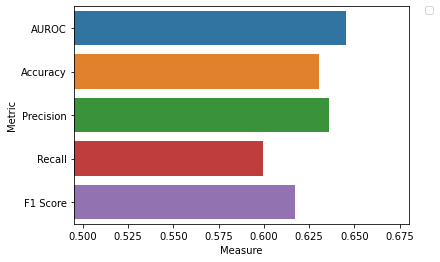

In [42]:
# recompose hierarcical data to dataframe
# Plot the performances of each metric
ax2 = sns.barplot(data=best_metrics, x='Measure', y='Metric', orient="h")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax2.set(xlim=(0.495, 0.68))
best_metrics

# Use the best model based on cross validation to obtain feature importance
numTrees = 30; maxDepth = 8; impurity = "entropy"; maxBins = 28; subsamplingRate = 1



In [20]:
# https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['importance'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('importance', ascending = False))

In [21]:
rf_best = RandomForestClassifier(numTrees=30, maxDepth=8, impurity = "entropy", maxBins = 28, subsamplingRate = 1, featuresCol='features', labelCol='white_result_vector', seed=SEED, leafCol="leafId")
model_pipeline = Pipeline(stages=[opening_vectorizor,
                                    gametype_vectorizer,
                                    result_vectorizor,
                                    move_encoder,
                                   features_assembler, 
                                   rf_best])
rtmodel = model_pipeline.fit(df)
df2 = rtmodel.transform(df)

In [22]:
featureimp = ExtractFeatureImp(rtmodel.stages[-1].featureImportances, df2, "features").head(20)
featureimp = featureimp.drop('vals', axis=1)
featureimp

,idx,name,importance
0,490,EloDiff,0.365457
12,10,ECO_Type_C40,0.138784
2,0,ECO_Type_A00,0.068527
7,5,ECO_Type_C20,0.044151
41,39,ECO_Type_C34,0.040995
53,51,ECO_Type_C22,0.038568
27,25,ECO_Type_D20,0.032479
10,8,ECO_Type_B20,0.031086
6,4,ECO_Type_C41,0.023108
21,19,ECO_Type_C02,0.022483


<AxesSubplot:ylabel='name'>

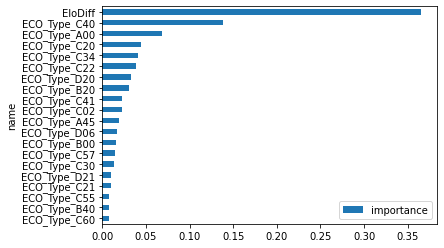

In [23]:
featureimp.sort_values('importance',inplace=True)
featureimp.plot.barh(x='name', y='importance', rot =0)

In [24]:
tree = rtmodel.stages[-1]
display(tree) #visualize the decision tree model
print(tree.toDebugString) #print the nodes of the decision tree model

RandomForestClassificationModel: uid=RandomForestClassifier_520f779c85ed, numTrees=30, numClasses=2, numFeatures=492

RandomForestClassificationModel: uid=RandomForestClassifier_520f779c85ed, numTrees=30, numClasses=2, numFeatures=492
  Tree 0 (weight 1.0):
    If (feature 130 in {1.0})
     Predict: 0.0
    Else (feature 130 not in {1.0})
     If (feature 51 in {1.0})
      Predict: 0.0
     Else (feature 51 not in {1.0})
      If (feature 7 in {1.0})
       Predict: 1.0
      Else (feature 7 not in {1.0})
       If (feature 15 in {1.0})
        Predict: 1.0
       Else (feature 15 not in {1.0})
        If (feature 17 in {1.0})
         Predict: 1.0
        Else (feature 17 not in {1.0})
         If (feature 62 in {1.0})
          Predict: 1.0
         Else (feature 62 not in {1.0})
          If (feature 113 in {1.0})
           Predict: 1.0
          Else (feature 113 not in {1.0})
           Predict: 0.0
  Tree 1 (weight 1.0):
    If (feature 490 <= 12.5)
     Predict: 0.0
    Else (feature 490 > 12.5)
     If (feature 35 in {1.0})
      Predict: 1.0
     Else (feature 35 not in {1.0})
      If (fe